# Final Assignment

## Problem Description:
In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. 
Both cities are very diverse and are the financial capitals of their respective countries. 
One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. 
In This assignment, i will explore the different perference between two cities in such area:
1. food perference
2. activity

## Loading all necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library
from project_lib import Project
project_id = 'eff77501-7a45-4196-b458-e1d9751a898e'
token = 'p-2b64743687b5a765b76d32a53665c901aeb4798a'
project = Project(None,project_id,token)

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
CLIENT_ID = 'JSUWSO0SGQBNIEPMF1WEUXY2512IHGKNMEKW55TFIJ342RME' # your Foursquare ID
CLIENT_SECRET = '1WRC4YIYDHJ2GJY1BKD2NUYTLAEQ1N3U25VQOUJPFNDFF0EN' # your Foursquare Secret
ACCESS_TOKEN = '2O4OM41GRE1YVF1BX5P3L02O04JBS0REMZE0WKRQWRGB52SK' # your FourSquare Access Token

print('Libraries imported.')

Libraries imported.


## 1. Downloading  and Preprocessing Necessary data of New York

In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

Data downloaded!
The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### 1.1 Preparing the Latitude and Longitude Data on Manhattan_data file

In [6]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 1.2 Defining the query

In [7]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Dunkin',Donut Shop,40.877136,-73.906666
4,Astral Fitness & Wellness Center,Gym,40.876705,-73.906372


## 1.3 Define helper method

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [9]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


## 1.4 Preprocessing the 

In [13]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()

## 1.5 Saving the Data into csv file

In [18]:
project.save_data(file_name = "Manhattan_grouped.csv",data = manhattan_grouped.to_csv(index=False))

{'file_name': 'Manhattan_grouped.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'pythonproject-donotdelete-pr-ffktrfcarodvhc',
 'asset_id': '675d431d-9549-452f-bcab-8282947601fb'}

## 1.6 Loading the file of Manhattan_grouped.csv

In [2]:
my_file = project.get_file("Manhattan_grouped.csv")
Manhattan_grouped = pd.read_csv(my_file, nrows=2000)

## 2. Loading Data of Toronto

### 2.1 Reading from csv file
Getting data from Previous assignment from saved csv file

In [3]:
my_file = project.get_file("toronto_grouped.csv")
Toronto_grouped = pd.read_csv(my_file, nrows=2000)

In [6]:
Toronto_grouped 

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.000000,0.0000,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.

#### Find out common columns from both manhattan and toronto

In [4]:
lm=list(Manhattan_grouped.columns)  
lt=list(Toronto_grouped.columns)
common_venues = list(set(lm).intersection(lt))
manhatton = Manhattan_grouped[common_venues]
toronto = Toronto_grouped[common_venues]

In [5]:
city = [0]*95
toronto['city'] = city

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [6]:
city = [1]*40
manhatton['city'] = city

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [7]:
# Concat toronto and manhatton dataframes
total = [toronto, manhatton]
result = pd.concat(total)

# Shuffling the data
result = result.sample(frac=1).reset_index(drop=True)

# preparing X and Y
X_list = list(result.columns)
X_list.remove('city')
X_list.remove('Neighborhood')
X = result[X_list]
Y = result['city']

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(X,Y)
print(pca.explained_variance_ratio_)

[0.1791934  0.08969857 0.07608998 0.05807413 0.04788279 0.04054614
 0.03506403 0.02539232 0.02421311 0.0219023 ]


#### Compute correlation 

In [9]:
all_cor = result.corr()

# 3. Lets find out what type of food people like in each city
extract Columns that containing 'Restaurant'

In [14]:
category = list(result.columns)
foods = ['city']
for ele in category:
    if 'Restaurant' in str(ele):
        foods.append(ele)
food_perfer = result[foods]

In [13]:
food_perfer.head()

,city,Ethiopian Restaurant,Taiwanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Cajun / Creole Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Chinese Restaurant,Eastern European Restaurant,Seafood Restaurant,Asian Restaurant,Caribbean Restaurant,Falafel Restaurant,Modern European Restaurant,Brazilian Restaurant,German Restaurant,American Restaurant,Latin American Restaurant,Dim Sum Restaurant,Mexican Restaurant,Korean Restaurant,Dumpling Restaurant,Filipino Restaurant,Greek Restaurant,French Restaurant,Molecular Gastronomy Restaurant,Restaurant,New American Restaurant,Fast Food Restaurant,Ramen Restaurant,Japanese Restaurant,Indian Restaurant,Mediterranean Restaurant,Sushi Restaurant,Italian Restaurant,Cuban Restaurant,Thai Restaurant
0,0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.0,0.010000,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.030000,0.01,0.000000,0.000000,0.010000,0.010000,0.000000,0.010000,0.030000,0.0,0.0
1,1,0.0,0.0,0.021053,0.010526,0.0,0.0,0.0,0.010526,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.010526,0.0,0.0,0.010526,0.0,0.0,0.0,0.0,0.031579,0.0,0.010526,0.00,0.010526,0.010526,0.021053,0.010526,0.010526,0.021053,0.021053,0.0,0.0
2,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.000000,0.0,0.031250,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.0,0.0
3,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


## 3.1 Plot the correlation Matrix through different types of Restaurant

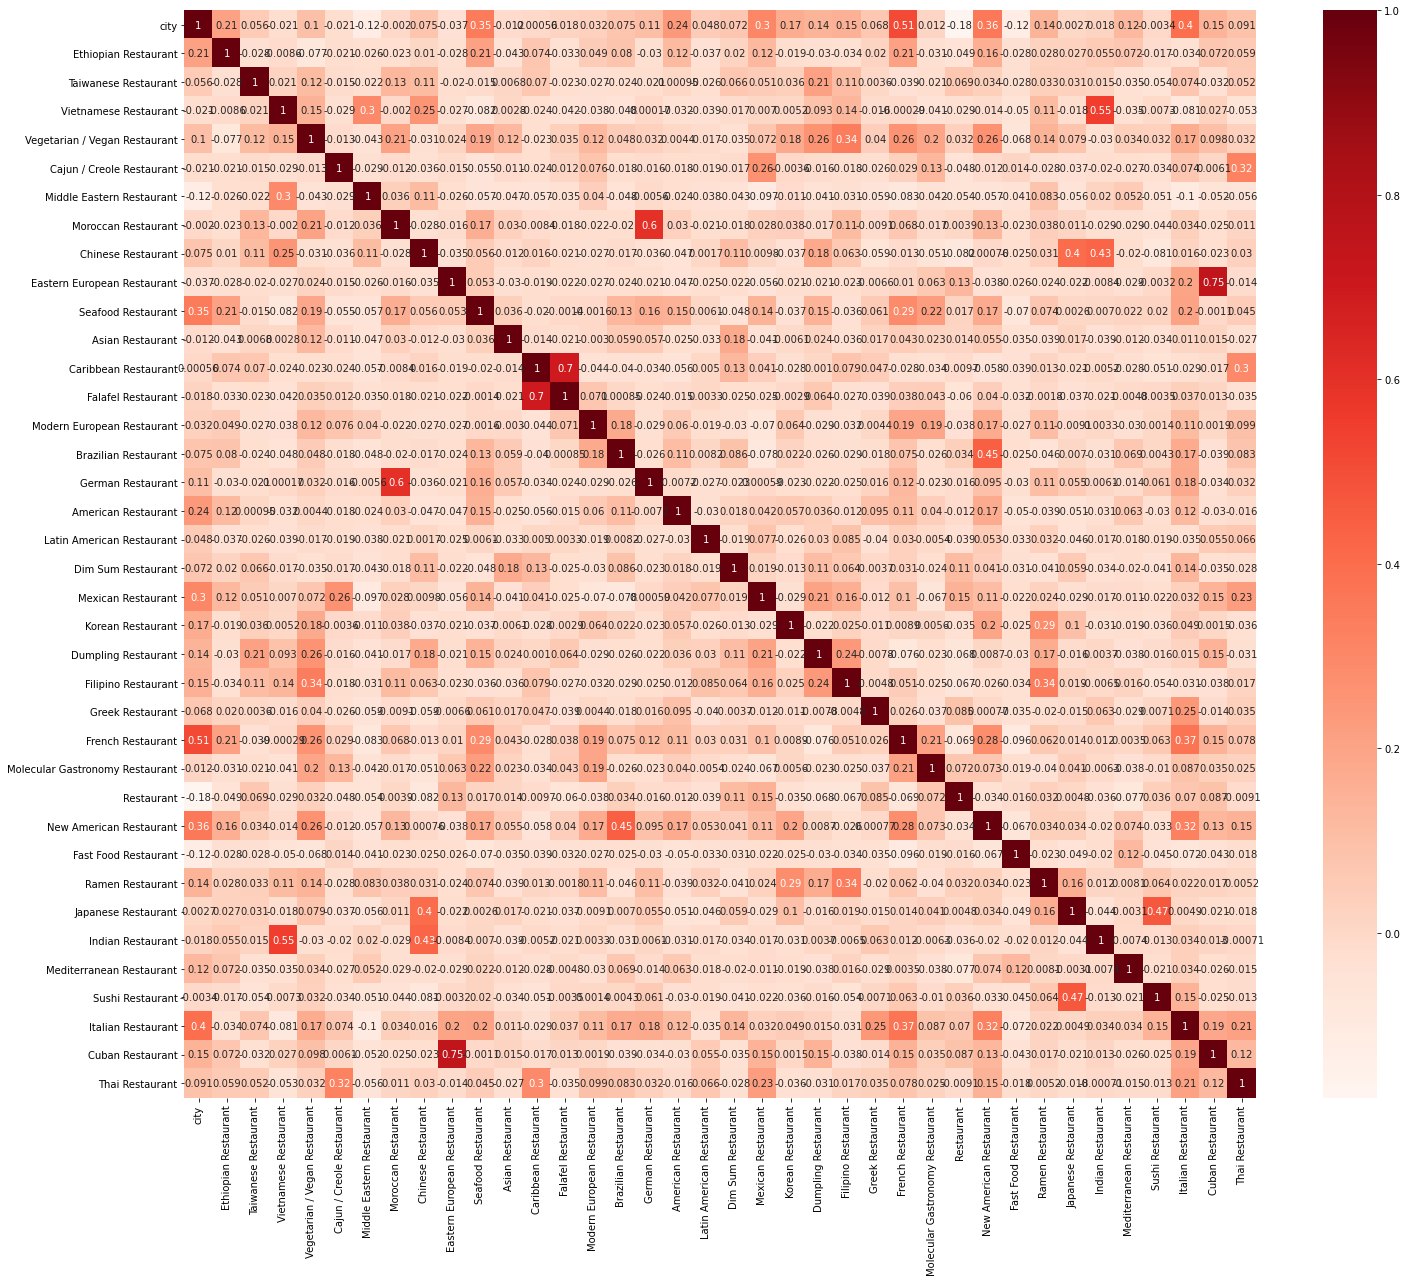

In [15]:
plt.figure(figsize=(24,20))
cor = food_perfer.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### 3.2 Print top 10 type of restaurants that make difference to the Cities

Top 5 correlated Restaurant
city                       1.000000
French Restaurant          0.507793
Italian Restaurant         0.396527
New American Restaurant    0.359222
Seafood Restaurant         0.348428
Name: city, dtype: float64

Top 5 uncorrelated Restaurant
Vietnamese Restaurant         -0.021166
Eastern European Restaurant   -0.036927
Fast Food Restaurant          -0.118185
Middle Eastern Restaurant     -0.121596
Restaurant                    -0.178740
Name: city, dtype: float64


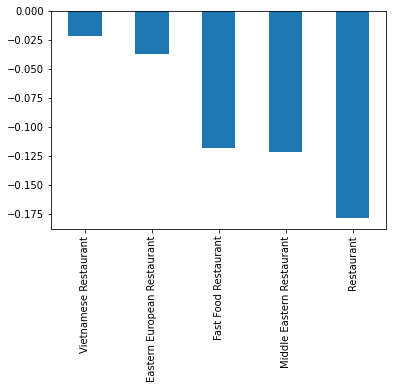

In [16]:
target = (cor['city']).sort_values(ascending=False)
print('Top 5 correlated Restaurant')
print(target[:5])
print('\nTop 5 uncorrelated Restaurant')
print(target[-5:])
target[-5:].plot(kind='bar')

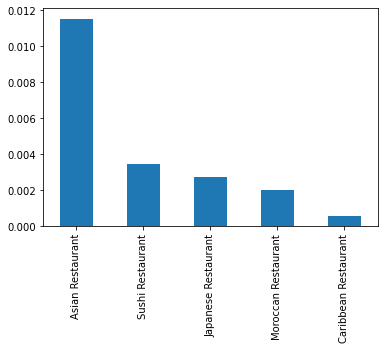

In [15]:
target = abs(cor['city']).sort_values(ascending=False)
target[-5:].plot(kind='bar')

### Conclusion:
The Occurance of French Restaurant, Italian Restaurant, New American Restaurant and Seafood Restaurant are differ significantly between New york and Toronto.
Sushi Restaurant, Japanese Restaurant, Moroccan Restaurant and Caribbean Restaurant are equally acceptable in Both New york and Toronto.

Let us find More about French Restaurant and Italian restaurant.

### 3.2.1 Comparing  Average distribution of French Restaurants in Both Manhatton and Toronto

In [43]:
avg_t = toronto['French Restaurant'].mean()
print('The mean value of French Restaurant across different Neighborhoods in Toront: ', avg_t)
avg_m = manhatton['French Restaurant'].mean()
print('The mean value of French Restaurant across different Neighborhoods in manhatton: ', avg_m)

The mean value of French Restaurant across different Neighborhoods in Toront:  0.0018879205707065124
The mean value of French Restaurant across different Neighborhoods in manhatton:  0.013599374245465576


#### Conclusion: people in New York are 10 times more like French Restaurant than people in Toronto

### 3.2.2 Comparing  Average distribution of Italian Restaurants in Both Manhatton and Toronto

In [44]:
avg_t = toronto['Italian Restaurant'].mean()
print('The mean value of Italian Restaurant across different Neighborhoods in Toront: ', avg_t)
avg_m = manhatton['Italian Restaurant'].mean()
print('The mean value of Italian Restaurant across different Neighborhoods in manhatton: ', avg_m)

The mean value of Italian Restaurant across different Neighborhoods in Toront:  0.011543799190055434
The mean value of Italian Restaurant across different Neighborhoods in manhatton:  0.03440391755923512


#### Conclusion: people in Manhatton are 3 times more like Italian Restaurant than in Toronto

## 3.3 Find out perfered type of Liquid for New York and Toronto 

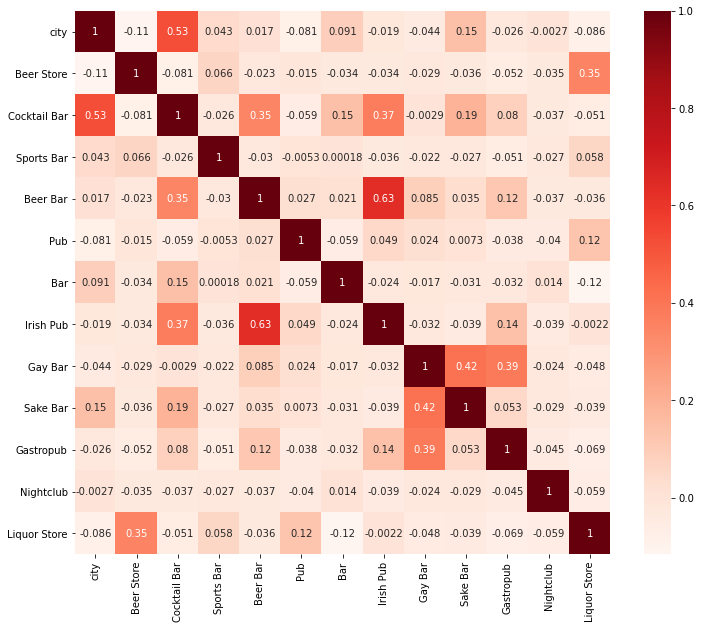

In [17]:
alcho_l = ['city','Beer Store','Cocktail Bar','Sports Bar','Beer Bar', 'Pub', 'Bar','Irish Pub', 'Gay Bar','Sake Bar', 'Gastropub', 'Nightclub', 'Liquor Store']
alcho_df = result[alcho_l]
alcho_corr = alcho_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(alcho_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

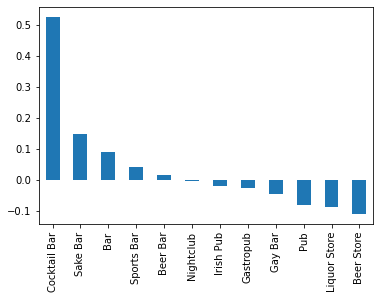

In [18]:
alcho_target = (alcho_corr['city']).sort_values(ascending=False)
plot_series = alcho_target[1:]
plot_series.plot(kind='bar')

## Conclusion: 
### Cocktail, Sake, at-home beer are top 3 that best describle the difference between New york and Toronto  
### However, people in both cities are like to have a beer in the bar and relax in NightClub 

In [24]:
avg_t = toronto['Cocktail Bar'].mean()
print('The mean value of Cocktail Bar across different Neighborhoods in Toront: ', avg_t)
avg_m = manhatton['Cocktail Bar'].mean()
print('The mean value of Cocktail Bar across different Neighborhoods in manhatton: ', avg_m)

The mean value of Cocktail Bar across different Neighborhoods in Toront:  0.001978110634278306
The mean value of Cocktail Bar across different Neighborhoods in manhatton:  0.01680073930091012


### People in New york are 8 times more like Cocktail Bar than in Toronto

In [25]:
avg_t = toronto['Sake Bar'].mean()
print('The mean value of Sake Bar across different Neighborhoods in Toront: ', avg_t)
avg_m = manhatton['Sake Bar'].mean()
print('The mean value of Sake Bar across different Neighborhoods in manhatton: ', avg_m)

The mean value of Sake Bar across different Neighborhoods in Toront:  0.00014619883040935673
The mean value of Sake Bar across different Neighborhoods in manhatton:  0.00075


### People in New york are 5 times more like Sake Bar than in Toronto

### Find out top 5 factors (Other than liquid and Restaurant) that best to explain the difference for people in New york and Toronto

In [20]:
all_target = (all_cor['city']).sort_values(ascending=False)
all_target[:]

city                               1.000000
Cocktail Bar                       0.526305
French Restaurant                  0.507793
Wine Bar                           0.470112
Deli / Bodega                      0.412125
Cosmetics Shop                     0.407636
Taco Place                         0.403443
Italian Restaurant                 0.396527
Spa                                0.367728
New American Restaurant            0.359222
Seafood Restaurant                 0.348428
Gym / Fitness Center               0.320095
Optical Shop                       0.317356
Art Gallery                        0.304777
Mexican Restaurant                 0.302094
Gourmet Shop                       0.299143
Hotel Bar                          0.290574
Building                           0.285515
Scenic Lookout                     0.283050
Steakhouse                         0.279544
Salad Place                        0.270071
Juice Bar                          0.268405
Bagel Shop                      

In [21]:
diff_cities = ['Cosmetics Shop', 'Spa', 'Gym / Fitness Center','Optical Shop','Art Gallery']
print('The top 5 venues that best explain difference between Toronto and New york are: ', diff_cities)

The top 5 venues that best explain difference between Toronto and New york are:  ['Cosmetics Shop', 'Spa', 'Gym / Fitness Center', 'Optical Shop', 'Art Gallery']


## 5 Final Conclusion
### Food and Drink style:
People in New York are more like to enjog french food, Italian Food, Seefood.
People in New York are more like to drink Cocktail, Sake and beer-in-Bar.
### Other Difference:
People in new york are more likely to go to Spa, Art Gallery, Gym, Cosmetics Shop and Optical Shop.
People in Toronto are more likely to go to Different Restaurant, Drink Bear at home, going to Discount Store.